# Model Predictive Control: Newell-Lee Evaporator

Using MPC, move the product composition X2 of the evaporator from 25% to 28% while keeping the separator level (L2) at 1.0 m, by manipulating F200, P100, and F2 every 1 min. Use a prediction horizon and control horizon of 10 min and 1 min respectively. 

In [5]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

Please recompile / update your pynumero_ASL library.
Time: 0 min to 10 min
Status: ok


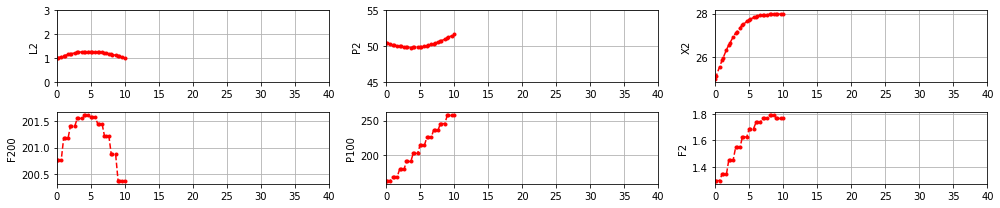

Time: 1 min to 11 min
Status: ok


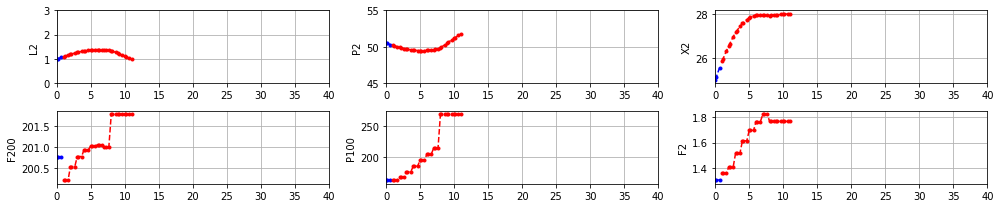

Time: 2 min to 12 min
Status: ok


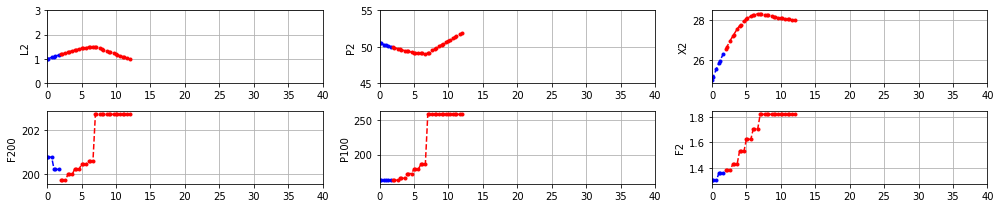

Time: 3 min to 13 min
Status: ok


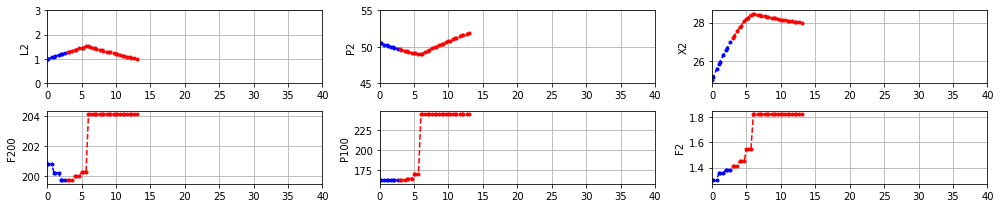

Time: 4 min to 14 min
Status: ok


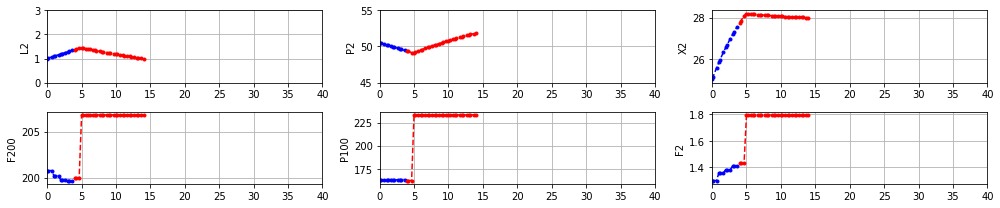

Time: 5 min to 15 min
Status: ok


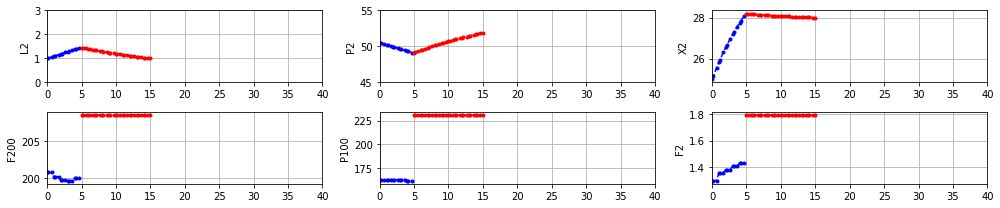

Time: 6 min to 16 min
Status: ok


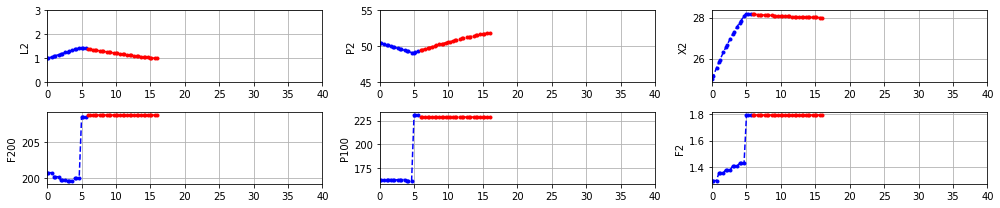

Time: 7 min to 17 min
Status: ok


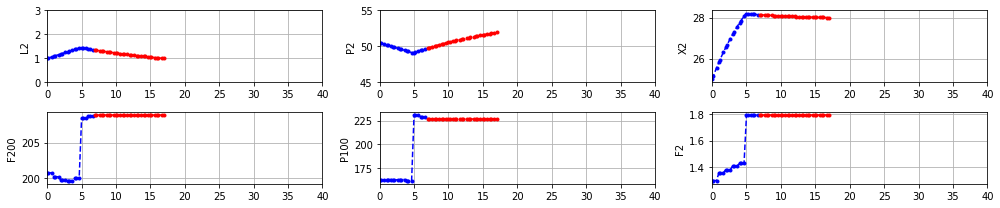

Time: 8 min to 18 min
Status: ok


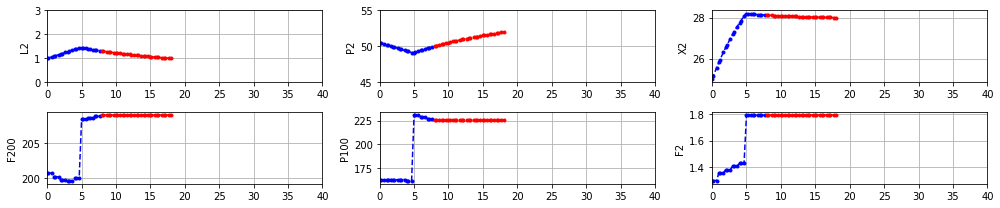

Time: 9 min to 19 min
Status: ok


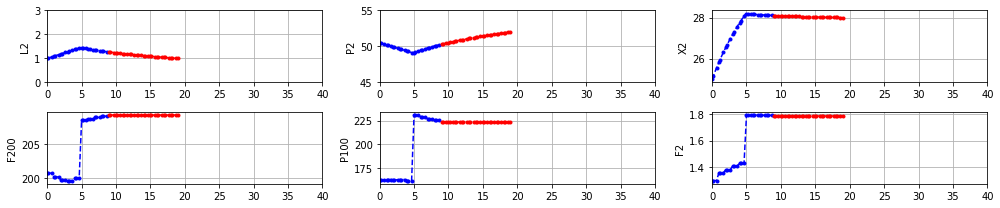

Time: 10 min to 20 min
Status: ok


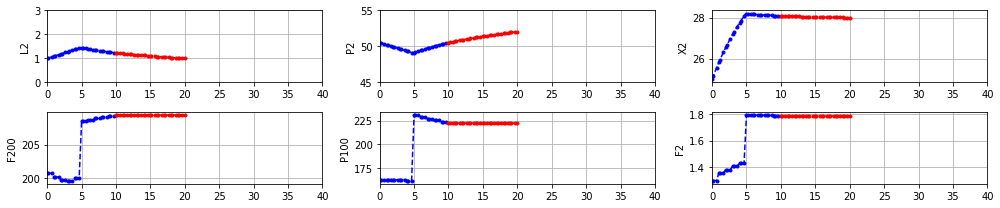

Time: 11 min to 21 min
Status: ok


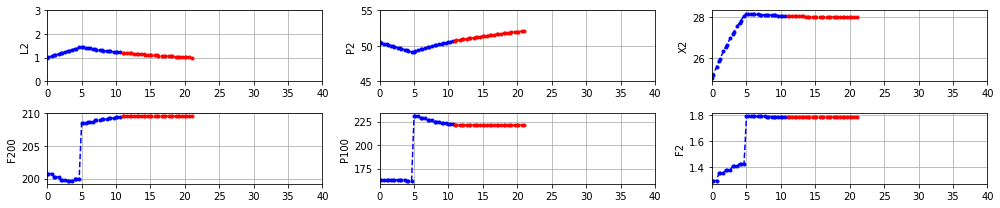

Time: 12 min to 22 min
Status: ok


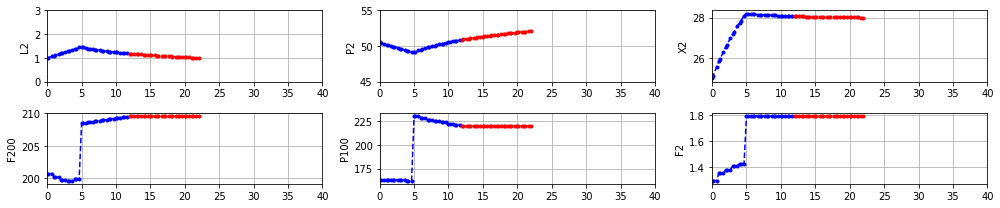

Time: 13 min to 23 min
Status: ok


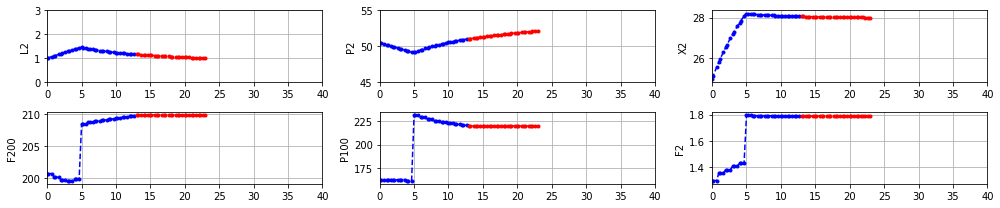

Time: 14 min to 24 min
Status: ok


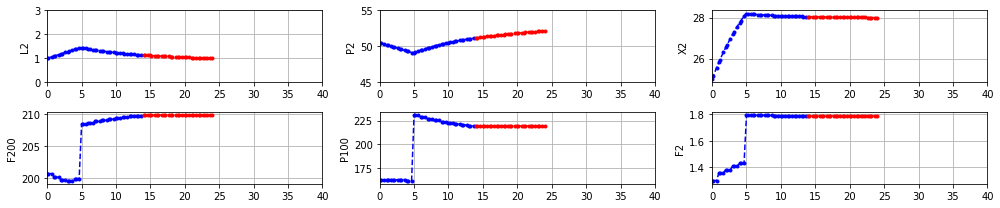

Time: 15 min to 25 min
Status: ok


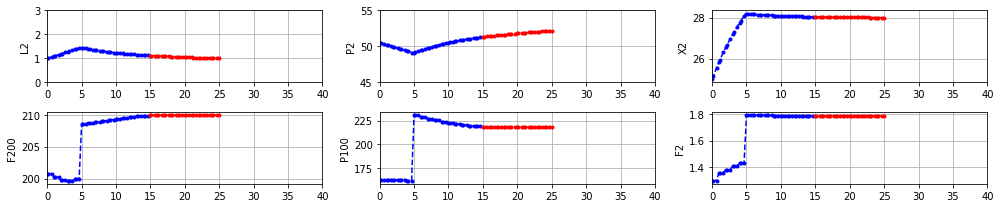

Time: 16 min to 26 min
Status: ok


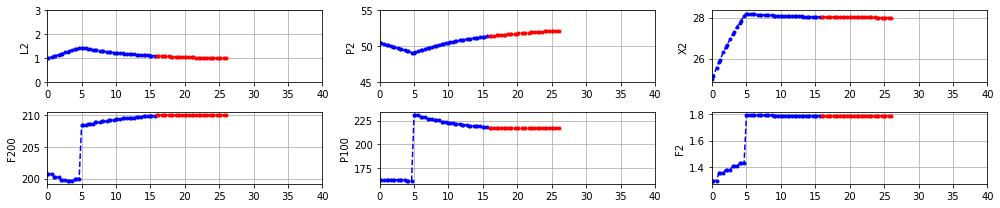

Time: 17 min to 27 min
Status: ok


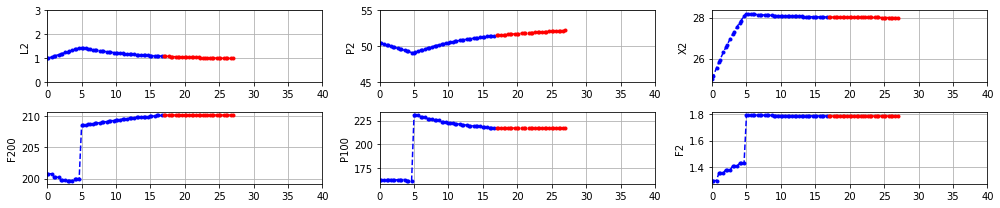

Time: 18 min to 28 min
Status: ok


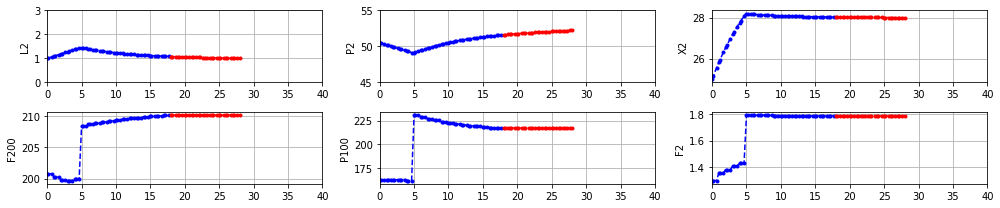

Time: 19 min to 29 min
Status: ok


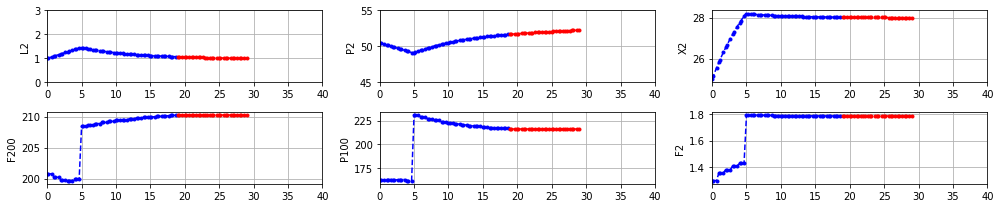

In [2]:
def solve_model(ti, tf, init_data):

    evap = ConcreteModel()

    evap.ti = Param(initialize=ti)
    evap.tf = Param(initialize=tf)
    evap.t = ContinuousSet(bounds=(evap.ti,evap.tf))
    
    # Setpoint for X2 and L2
    evap.X2_sp = Param(initialize=28)
    evap.L2_sp = Param(initialize=1)

    # States
    evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
    evap.P2 = Var(evap.t, initialize=50.5)
    evap.X2 = Var(evap.t, initialize=25)

    # Inputs and Disturbances
    evap.F200 = Var(evap.t, initialize=208)   # Manipulated var
    evap.P100 = Var(evap.t, initialize=194.7) # Manipulated var
    evap.F2 = Var(evap.t, initialize=2)       # Manipulated var
    
    evap.T200 = Param(evap.t, default=25)
    evap.F1 = Param(evap.t, default=10)
    evap.F3 = Param(evap.t, default=50)
    evap.X1 = Param(evap.t, default=5)
    evap.T1 = Param(evap.t, default=40)
    
    evap.F200u = VarList(domain=NonNegativeReals, initialize=200, bounds=(100, 300))
    evap.P100u = VarList(domain=NonNegativeReals, initialize=200, bounds=(100, 300))
    evap.F2u = VarList(domain=NonNegativeReals, initialize=2, bounds=(0, 4))
    for i in range(10):
        evap.F200u.add()
        evap.P100u.add()
        evap.F2u.add()

    # Other outputs
    evap.F4 = Var(evap.t, initialize=8)
    evap.F5 = Var(evap.t, initialize=8)
    evap.T2 = Var(evap.t, initialize=84.6)
    evap.T3 = Var(evap.t, initialize=80.6)
    evap.F100 = Var(evap.t, initialize=9.27)
    evap.T100 = Var(evap.t, initialize=119.9)
    evap.Q100 = Var(evap.t, initialize=339.2)
    evap.T201 = Var(evap.t, initialize=46.15)
    evap.Q200 = Var(evap.t, initialize=308)

    # Setup derivative vars for states
    evap.dL2dt = DerivativeVar(evap.L2, initialize=init_data['dL2dt'])
    evap.dP2dt = DerivativeVar(evap.P2, initialize=init_data['dP2dt'])
    evap.dX2dt = DerivativeVar(evap.X2, initialize=init_data['dX2dt'])

    # Set an objective
    evap.obj = Objective(expr=sum([((evap.X2[i]-evap.X2_sp)/25)**2 + \
                                   (evap.L2[i]-evap.L2_sp)**2 \
                                   for i in evap.t]), sense=minimize)

    evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
    evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
    evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

    # Other constraints
    evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                          m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
    evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                          m.T3[i] == 0.507*m.P2[i] + 55)
    evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                          m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
    evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                          m.T100[i] == 0.1538*m.P100[i] + 90)
    evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
    evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                          m.F100[i]*36.6 == m.Q100[i])
    evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
    evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                          m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
    evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                          m.F5[i]*38.5 == m.Q200[i])

    def _init(m):
        yield m.L2[evap.ti] == init_data['L2']
        yield m.P2[evap.ti] == init_data['P2']
        yield m.X2[evap.ti] == init_data['X2']
    
    evap.initcon = ConstraintList(rule=_init)
    
    def _stepF200(m, i):
        if evap.ti+i < 1:
            return m.F200[i] == m.F200u[1]
        elif evap.ti+i < 2:
            return m.F200[i] == m.F200u[2]
        elif evap.ti+i < 3:
            return m.F200[i] == m.F200u[3]
        elif evap.ti+i < 4:
            return m.F200[i] == m.F200u[4]
        elif evap.ti+i < 5:
            return m.F200[i] == m.F200u[5]
        elif evap.ti+i < 6:
            return m.F200[i] == m.F200u[6]
        elif evap.ti+i < 7:
            return m.F200[i] == m.F200u[7]
        elif evap.ti+i < 8:
            return m.F200[i] == m.F200u[8]
        elif evap.ti+i < 9:
            return m.F200[i] == m.F200u[9]
        else:
            return m.F200[i] == m.F200u[10]

    evap.stepF200 = Constraint(evap.t, rule=_stepF200)

    def _stepP100(m, i):
        if evap.ti+i < 1:
            return m.P100[i] == m.P100u[1]
        elif evap.ti+i < 2:
            return m.P100[i] == m.P100u[2]
        elif evap.ti+i < 3:
            return m.P100[i] == m.P100u[3]
        elif evap.ti+i < 4:
            return m.P100[i] == m.P100u[4]
        elif evap.ti+i < 5:
            return m.P100[i] == m.P100u[5]
        elif evap.ti+i < 6:
            return m.P100[i] == m.P100u[6]
        elif evap.ti+i < 7:
            return m.P100[i] == m.P100u[7]
        elif evap.ti+i < 8:
            return m.P100[i] == m.P100u[8]
        elif evap.ti+i < 9:
            return m.P100[i] == m.P100u[9]
        else:
            return m.P100[i] == m.P100u[10]

    evap.stepP100 = Constraint(evap.t, rule=_stepP100)

    def _stepF2(m, i):
        if evap.ti+i < 1:
            return m.F2[i] == m.F2u[1]
        elif evap.ti+i < 2:
            return m.F2[i] == m.F2u[2]
        elif evap.ti+i < 3:
            return m.F2[i] == m.F2u[3]
        elif evap.ti+i < 4:
            return m.F2[i] == m.F2u[4]
        elif evap.ti+i < 5:
            return m.F2[i] == m.F2u[5]
        elif evap.ti+i < 6:
            return m.F2[i] == m.F2u[6]
        elif evap.ti+i < 7:
            return m.F2[i] == m.F2u[7]
        elif evap.ti+i < 8:
            return m.F2[i] == m.F2u[8]
        elif evap.ti+i < 9:
            return m.F2[i] == m.F2u[9]
        else:
            return m.F2[i] == m.F2u[10]

    evap.stepF2 = Constraint(evap.t, rule=_stepF2)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(evap, nfe=10, ncp=3, scheme='LAGRANGE-RADAU')

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(evap)
    
    model_vars = evap.component_map(ctype=Var)
    model_params = evap.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        if v.name[-1] != 'u':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    evap_df = pd.concat(s_list, axis=1)
    evap_df.columns = col_list
    return evap_df, res
    
init_data = {'L2':1,    'P2':50.5, 'X2':25,
             'dL2dt':0, 'dP2dt':0, 'dX2dt':0}

# Initialize the data frame
evap_df = pd.DataFrame(columns=['L2', 'P2', 'X2', 'F200', 'P100', 'F2', 'F4',
                                'F5', 'T2', 'T3', 'F100', 'T100', 'Q100', 
                                'T201', 'Q200', 'dL2dt', 'dP2dt', 'dX2dt'])

for j in np.arange(0, 20, 1): # start, last, increment
    
    # Simulate the model at time [j, j+10]
    temp_df, res = solve_model(j, j+10, init_data)
    print(f"Time: {j} min to {j+10} min")
    print(f"Status: {res.Solver.status}")
    
    # Save the last condition as the next initial condition
    for k in init_data.keys():
        init_data[k] = temp_df.iloc[3][k] # 4th row is at 1 min
    
    # Plot the current prediction horizon
    ctr = 1
    plt.figure(figsize=(14, 3))
    #plot_df = pd.concat([evap_df, temp_df], axis=0)
    for k in evap_df.columns[:6]:
        plt.subplot(2, 3, ctr)
        plt.plot(evap_df.index, evap_df[k].values, 'b.--')
        plt.plot(temp_df.index, temp_df[k].values, 'r.--')
        #plt.plot(plot_df[k].index, plot_df[k].values,'b.--')
        plt.xlim([0, 40])
        if ctr == 1:
            plt.ylim([0, 3])
        elif ctr == 2:
            plt.ylim([45, 55])
        plt.grid()
        plt.ylabel(k)
        ctr += 1
        
    plt.tight_layout()
    plt.show()
    
    # Append temp_df after evap_df
    evap_df = pd.concat([evap_df, temp_df.iloc[:3,:]], axis=0)

## Plot the final variable histories

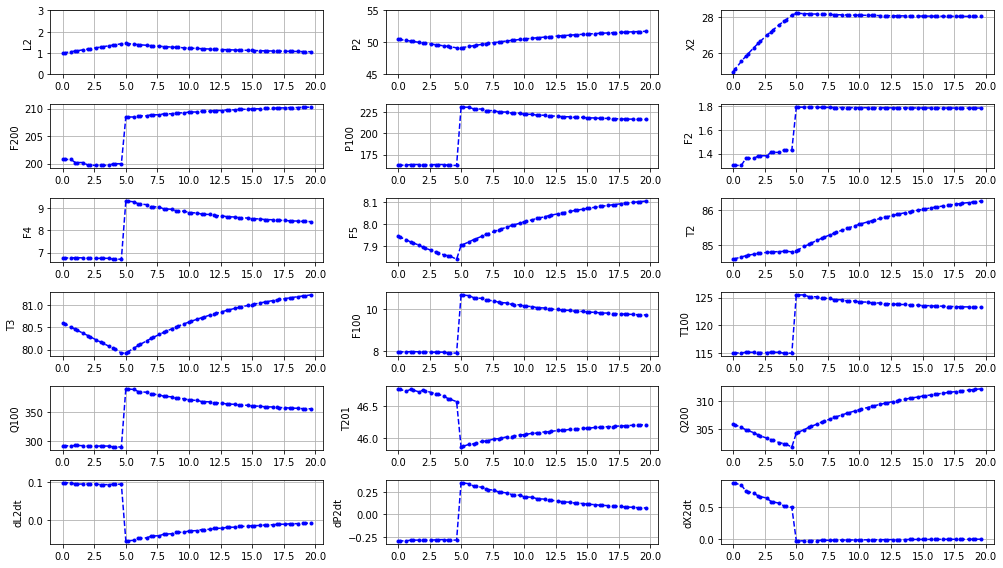

In [3]:
ctr = 1
plt.figure(figsize=(14, 8))
for k in evap_df.columns:
    plt.subplot(6, 3, ctr)
    plt.plot(evap_df[k].index, evap_df[k].values,'b.--')
    if ctr == 1:
        plt.ylim([0, 3])
    elif ctr == 2:
        plt.ylim([45, 55])
    plt.grid()
    plt.ylabel(k)
    ctr += 1
    
plt.tight_layout()
plt.show()

In [4]:
evap_df.head(20)

,L2,P2,X2,F200,P100,F2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200,dL2dt,dP2dt,dX2dt
0.000000,1.000000,50.500000,25.000000,200.761461,162.496776,1.298841,6.765805,7.945128,84.605800,80.603500,7.970152,114.992004,291.707560,46.766231,305.887429,0.096768,-0.294831,0.876449
0.155051,1.014707,50.455531,25.133834,200.761461,162.496776,1.298841,6.761294,7.941906,84.622663,80.580954,7.965729,114.992004,291.545679,46.757406,305.763399,0.096993,-0.295153,0.867758
0.644949,1.063251,50.307276,25.556038,200.761461,162.496776,1.298841,6.748259,7.931166,84.671384,80.505789,7.952950,114.992004,291.077954,46.727982,305.349899,0.097645,-0.295727,0.840339
1.000000,1.095977,50.210429,25.841974,200.204292,163.290908,1.358006,6.769352,7.919836,84.706378,80.456688,7.975807,115.114142,291.914530,46.757325,304.913691,0.093632,-0.287621,0.745323
1.155051,1.110250,50.166803,25.955430,200.204292,163.290908,1.358006,6.766419,7.916677,84.717344,80.434569,7.972931,115.114142,291.809258,46.748647,304.792078,0.093779,-0.287565,0.737619
1.644949,1.157001,50.023368,26.314962,200.204292,163.290908,1.358006,6.757901,7.906292,84.749181,80.361848,7.964580,115.114142,291.503626,46.720117,304.392238,0.094205,-0.287098,0.713207
2.000000,1.188857,49.927738,26.555338,199.698025,162.978807,1.380812,6.740197,7.895441,84.770617,80.313363,7.946367,115.066141,290.837029,46.745296,303.974492,0.093950,-0.288811,0.666603
2.155051,1.203247,49.883620,26.656739,199.698025,162.978807,1.380812,6.738346,7.892249,84.777538,80.290995,7.944552,115.066141,290.770588,46.736503,303.851568,0.094042,-0.288476,0.659603
2.644949,1.249891,49.740838,26.978329,199.698025,162.978807,1.380812,6.732904,7.881915,84.797880,80.218605,7.939216,115.066141,290.575302,46.708044,303.453745,0.094314,-0.287253,0.637400
3.000000,1.282230,49.643114,27.192690,199.683168,163.287870,1.409527,6.741511,7.874728,84.810008,80.169059,7.948503,115.113674,290.915197,46.689863,303.177033,0.092448,-0.283304,0.583558
